<a href="https://colab.research.google.com/github/fastai-energetic-engineering/ashrae/blob/master/ASHRAE_energy_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASHRAE Energy Prediction

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastai, kaggle]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: false


In [1]:
#collapse
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 27.8MB/s 
     |████████████████████████████████| 1.2MB 50.3MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 194kB 52.1MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
Mounted at /content/gdrive


In [13]:
#collapse
#from fastbook import *
import os
#from google.colab import files
import pandas as pd
import datetime as dt

from fastai.tabular.all import *


In [3]:
# Load ASHRAE energy dataset from your google drive
p = 'gdrive/MyDrive/Colab Notebooks/ashrae'
os.chdir(p)

## Joining Tables

Our training data comprised of three tables:
- `building_metadata.csv`
- `weather_train.csv`
- `train.csv`

We need to join the tables. First, let's see what's in the tables.

In [4]:
building = pd.read_csv('data/building_metadata.csv')
weather = pd.read_csv('data/weather_train.csv')
train = pd.read_csv('data/train.csv')

`building` contains the buildings' metadata.

In [5]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


- `site_id` - Foreign key for the weather files.
- `building_id` - Foreign key for training.csv
- `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
- `square_feet` - Gross floor area of the building
- `year_built` - Year building was opened
- `floor_count` - Number of floors of the building

`weather` contains weather data from the closest meteorological station.

In [6]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


- `site_id`
- `air_temperature` - Degrees Celsius
- `cloud_coverage` - Portion of the sky covered in clouds, in oktas
- `dew_temperature` - Degrees Celsius
- `precip_depth_1_hr` - Millimeters
- `sea_level_pressure` - Millibar/hectopascals
- `wind_direction` - Compass direction (0-360)
- `wind_speed` - Meters per second

Finally, `train` contains the target variable, `meter reading`, which represents energy consumption in kWh.

In [7]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


- `building_id` - Foreign key for the building metadata.
- `meter` - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
- `timestamp` - When the measurement was taken
- `meter_reading` - The target variable. Energy consumption in kWh (or equivalent).

Apparently there was some issues regarding the timestamps, as noted by [this post](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115040#latest-667889). The timestamp in the weather and meter reading table were in GMT and local time, respectively. We have to keep this in mind before merging the tables.

Here I wrote a function that can prepare train and test data accordingly.

In [14]:
def prepare_data(type='train'):
    assert type in ['train', 'test']
    
    # read data
    building = pd.read_csv('data/building_metadata.csv')
    weather = pd.read_csv(f'data/weather_{type}.csv')
    data = pd.read_csv(f'data/{type}.csv')

    # convert datetime
    data['timestamp'] = pd.to_datetime(data['timestamp'])

    # adjust timestamp
    timediff = {0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4}
    weather['time_diff']= weather['site_id'].map(timediff)
    weather['time_diff'] = weather['time_diff'].apply(lambda x: dt.timedelta(hours=x))
    weather['timestamp_gmt'] = pd.to_datetime(weather['timestamp'])
    weather['timestamp'] = weather['timestamp_gmt'] - weather['time_diff']

    # merge table
    data = data.merge(building, on='building_id', how='left')
    data = data.merge(weather, on=['site_id','timestamp'], how='left')

    return data

Let's try this function out!

In [15]:
train = prepare_data('train')
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,time_diff,timestamp_gmt
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,0 days 04:00:00,2016-01-01 04:00:00
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,0 days 04:00:00,2016-01-01 04:00:00
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,0 days 04:00:00,2016-01-01 04:00:00
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,0 days 04:00:00,2016-01-01 04:00:00
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,0 days 04:00:00,2016-01-01 04:00:00


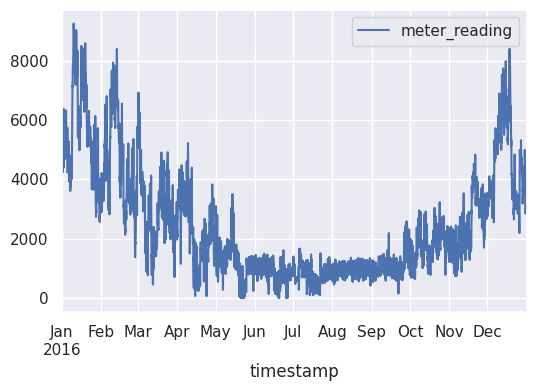

In [27]:
# Get a subset of the data, just one building and meter

t = train[(train['building_id']==1126) & (train['meter']==2)]
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100
sns.set()
#%matplotlib inlinefig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
t[['timestamp', 'meter_reading']].set_index('timestamp').plot()


In [35]:
# Use an IndexSplitter and load using TabularPandas then to a dataloader

#t = t[['building_id', 'meter_reading','meter','air_temperature']]

# 2-fold cross-validation. Build 2 models, each with half the year as training data
splits1=MaskSplitter(t['timestamp'] < '2016-07-01')(range_of(t))
to1 = TabularPandas(t, procs=[Categorify, FillMissing, Normalize],
                   cat_names = ['building_id', 'meter'],
                   cont_names = ['air_temperature'],
                   y_names='meter_reading',
                   splits=splits1)
dls1 = to1.dataloaders(bs=64)

Load entire dataset or subset:

In [ ]:
#@title
# Load the entire dataset into a TabularDataLoader

cat_names = ['building_id', 'meter', 'site_id', 'primary_use']
#cont_names = ['timestamp', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'time_diff', 'timestamp_gmt']
cont_names = ['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(train.head(64*64), procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="meter_reading")

In [ ]:
#@title
# Load a smaller dataset into a TabularDataLoader

t = train[['meter_reading','building_id','meter','air_temperature']]
from fastai.tabular.all import *
cat_names = ['building_id','meter']
cont_names = ['air_temperature']
procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(t.head(64*1000), procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="meter_reading")

In [37]:
dls1.show_batch()

,building_id,meter,air_temperature_na,air_temperature,meter_reading
0,1126,2,False,18.299999,1175.780029
1,1126,2,False,-0.600000,2845.699951
2,1126,2,False,18.299999,1110.349976
3,1126,2,False,12.800000,1410.160034
4,1126,2,False,-12.199999,5880.859863
5,1126,2,False,-6.100000,5316.410156
6,1126,2,False,28.299999,1125.979980
7,1126,2,False,21.700001,934.570007
8,1126,2,False,17.799999,875.000000
9,1126,2,False,17.799999,853.515991


In [39]:
# Train a model

learn = tabular_learner(dls1, metrics=rmse)
learn.summary()
# Exploring the learning rates
#learn.lr_find(stop_div=False)
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,_rmse,time
0,6057103.000000,12221182.000000,3495.880859,00:01
1,6037638.000000,12145011.000000,3484.969238,00:00
2,5990491.000000,12075947.000000,3475.046387,00:00
3,5987513.500000,12039745.000000,3469.833496,00:00
4,5952982.500000,12029795.000000,3468.399658,00:00


In [ ]:
learn.show_results()

,building_id,meter,air_temperature,meter_reading,meter_reading_pred
0,1.0,1.0,-1.700000,3389.649902,NaN
1,1.0,1.0,-1.100000,4208.009766,NaN
2,1.0,1.0,14.400000,581.054993,NaN
3,1.0,1.0,8.900000,2277.340088,NaN
4,1.0,1.0,21.100000,595.703003,NaN
5,1.0,1.0,29.400000,127.930000,NaN
6,1.0,1.0,-7.200000,4558.589844,NaN
7,1.0,1.0,26.700001,916.015991,NaN
8,1.0,1.0,-5.000000,5277.339844,NaN


In [ ]:
from sklearn.tree import *
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);


array([  127.23632903, 25019.92146783,   127.23632903, ...,   696.93540397,   696.93540397,   127.23632903])

To do:


1.   Figure out why continuous variables are shown as boolean
2.   Handle dates
3.   Create training and validation sets, rather than using TabularDataLoader

